This notebook implements a simple cluster-based filtering on building point cloud, detects building facade orientations and projects points to building facade planes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import laspy
from sklearn.mixture import GaussianMixture
from lidar.point_cloud_processings import remove_noise, create_bev_density_map, project_point_cloud_vertical

### Set input point cloud file

In [3]:
las_file_path = r"C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\QA4lidar\2_clipped_buffered.las"

### Filter point cloud

In [4]:
with laspy.open(las_file_path) as las:
    las_data = las.read()
    points = np.vstack((las_data.x, las_data.y, las_data.z)).T
# Remove noise points using DBSCAN
eps = 3  # Maximum distance between points to be considered neighbors (meters)
min_samples = 2  # Minimum number of points to form a cluster
filtered_points = remove_noise(points, eps, min_samples)

### Create top-down view density map

In [5]:
# Define x_limits and y_limits based on the extent of filtered points
x_limits = (filtered_points[:, 0].min(), filtered_points[:, 0].max())
y_limits = (filtered_points[:, 1].min(), filtered_points[:, 1].max())
resolution = 0.3  # meters

# Create BEV density map
bev_density_map = create_bev_density_map(points, x_limits, y_limits, resolution)
bev_density_map_thresh = bev_density_map>0.3

### Detect lines from density map
* Two lines are calculated
* Orientations of the detected lines will be potential facade orientations

In [6]:
# Apply Gaussian filtering to smooth the density map
# smoothed_map = gaussian_filter(bev_density_map.astype(np.float32), sigma=2)

# Detect lines using Gaussian Mixture Model
X, Y = np.meshgrid(
    np.linspace(x_limits[0], x_limits[1], bev_density_map.shape[1]),
    np.linspace(y_limits[0], y_limits[1], bev_density_map.shape[0])
)
coords = np.vstack((X[bev_density_map_thresh > 0].ravel(), Y[bev_density_map_thresh > 0].ravel())).T

gmm = GaussianMixture(n_components=2, random_state=42).fit(coords)
line_centers = gmm.means_
line_covariances = gmm.covariances_

c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


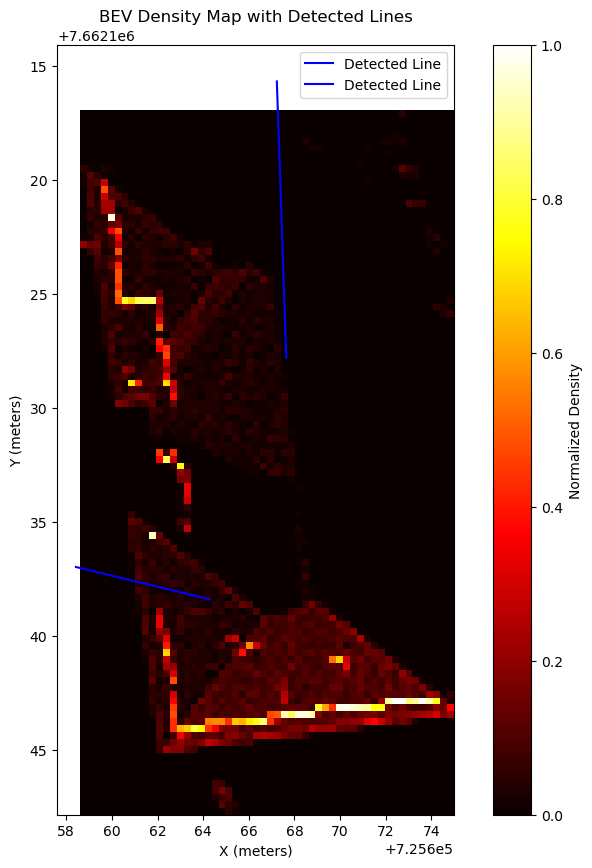

Line 1 orientation angle: -91.96°
Line 2 orientation angle: -166.41°


In [7]:
# Visualize the results
# Draw points along the lines represented by the GMM
line_points = []
line_angles = []
for mean, cov in zip(line_centers, line_covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov[:2, :2])
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    line_angles.append(np.degrees(angle))
    t = np.linspace(-5, 5, 500)  # Generate points along the line
    line = mean[:2] + t[:, None] @ (eigenvectors[:, 0][None, :] * np.sqrt(eigenvalues[0]))
    line_points.append(line)
plt.figure(figsize=(10, 10))
plt.imshow(bev_density_map, cmap="hot", extent=[*x_limits, *y_limits])
plt.colorbar(label="Normalized Density")
for line in line_points:
    plt.plot(line[:, 0], line[:, 1], c="blue", label="Detected Line")
# plt.scatter(line_centers[:, 0], line_centers[:, 1], c="blue", label="Detected Lines", s=50)
plt.title("BEV Density Map with Detected Lines")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.gca().invert_yaxis()  # Invert y-axis to match BEV perspective
plt.legend()
plt.show()
# Print orientation angles of the detected lines
for i, angle in enumerate(line_angles):
    print(f"Line {i + 1} orientation angle: {angle:.2f}°")

### Project points to facade(s)
* Calculate mean elevation for each points projected to the same pixel

x' range: -7682474.008016973 -7682442.8725425005
z range: 8.4 12.59
Elevation range (original z): 8.4 12.59


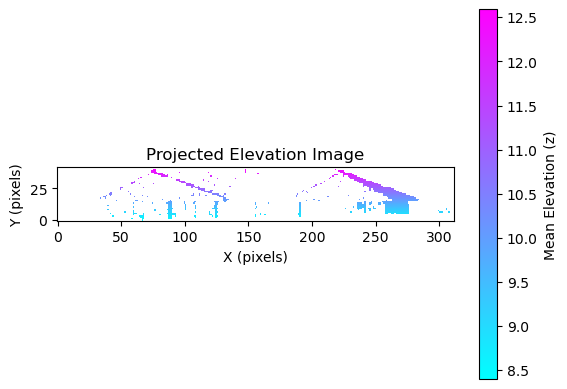

In [8]:
orientation_angle = (-1.0)*line_angles[0]  #TODO: Vertical plane orientation in degrees
pixel_size = 0.1  # Resolution
elevation_image = project_point_cloud_vertical(filtered_points, orientation_angle, pixel_size)

# Visualize
plt.imshow(elevation_image, cmap='cool', origin='lower')
plt.colorbar(label='Mean Elevation (z)')
plt.title('Projected Elevation Image')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()